# Sistem Rekomendasi Destinasi Wisata Kota Bandung Berbasis Collaborative Filtering
<hr>

#### Sumber data: https://www.kaggle.com/aprabowo/indonesia-tourism-destination
#### Oleh: [Rafka Imanda Putra](https://www.kaggle.com/rafkaip)

# Pendahuluan

<div>
<img src="https://static.limakaki.com/2017/07/slide_12.jpg" width="900";/>
</div>

Sebelum bepergian, biasanya seseorang akan membuat rencana terlebih dahulu tentang lokasi yang akan dikunjungi dan waktu keberangkatannya. Hal ini dilakukan untuk perencanaan sebelum berwisata ke suatu Kota.

Kota Bandung memiliki daya tarik wisata yang cukup tinggi, namun dikutip dari humas.bandung.go.id/ jumlah wisatawan ke Kota Bandung turun 50% pada tahun 2021. Tentunya angka ini wajar karena penyebaran Covid-19 yang mengkhawatirkan di Indonesia.

Untuk periode Oktober 2021, sejumlah wisata di Kota Bandung sudah mulai beroperasi, ini akan menjadi momentum yang tepat untuk menggerakkan pariwisata kembali.

Pada projek ini, saya akan membuat sebuah sistem rekomendasi berbasis collaborative filtering untuk menampilkan top-n recommendation destinasi wisata di Kota Bandung berdasarkan data user, rating, dan place

# Alur Proses

## 1. Mengimpor Library Python yang Dibutuhkan

In [ ]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

##### Keterangan:
* tourism_with_id.csv - mengandung informasi tempak wisata di 5 kota besar di Indonesia (hanya kota Bandung yang dipakai)
* user.csv - mengandung informasi pengguna untuk membuat rekomendasi fitur berdasar pengguna
* tourism_rating.csv - mengandung informasi pengguna, tempat wisata, dan rating untuk membuat sistem rekomendasi berdasar rating


## 3. Data Understanding

### 3.1 Menyiapkan Data

In [ ]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('/home/tourism_rating.csv')
place = pd.read_csv('/home/tourism_with_id.csv')
user = pd.read_csv('/home/user.csv')

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [ ]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1.0,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1.0
1,2.0,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2.0


In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1.0,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2.0,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [ ]:
merged_data = pd.merge(rating, place[['Place_Id', 'Category']], on='Place_Id', how='left')

merged_data.head(5)

,User_Id,Place_Id,Place_Ratings,Unnamed: 3,Unnamed: 4,Category
0,1,179,3,NaN,NaN,Budaya
1,1,344,2,NaN,NaN,Bahari
2,1,5,5,NaN,NaN,Taman Hiburan
3,1,373,3,NaN,NaN,Budaya
4,1,101,4,NaN,NaN,Budaya


In [ ]:
# Merubah data agar hanya dari Kota Bandung

place = place[place['City']=='Malang']
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
437,438.0,Jatim Park 1,Taman rekreasi edukasi dengan berbagai wahana ...,Taman Rekreasi,Malang,NaN,4.5,NaN,"{'lat': -7.883131, 'lng': 112.533232}",-7.883131,112.533232
438,439.0,Jatim Park 2 (Batu Secret Zoo & Museum Satwa),Kebun binatang modern dan museum satwa dengan ...,"Kebun Binatang, Museum",Malang,NaN,4.7,NaN,"{'lat': -7.883479, 'lng': 112.533682}",-7.883479,112.533682


In [ ]:
place.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 437 to 493
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      57 non-null     float64
 1   Place_Name    57 non-null     object 
 2   Description   57 non-null     object 
 3   Category      57 non-null     object 
 4   City          57 non-null     object 
 5   Price         2 non-null      float64
 6   Rating        57 non-null     float64
 7   Time_Minutes  0 non-null      float64
 8   Coordinate    57 non-null     object 
 9   Lat           57 non-null     float64
 10  Long          57 non-null     float64
dtypes: float64(6), object(5)
memory usage: 5.3+ KB


In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

#### 3.2.2. Data rating

In [ ]:
# melihat gambaran data rating

merged_data.head()

,User_Id,Place_Id,Place_Ratings,Unnamed: 3,Unnamed: 4,Category
0,1,179,3,NaN,NaN,Budaya
1,1,344,2,NaN,NaN,Bahari
2,1,5,5,NaN,NaN,Taman Hiburan
3,1,373,3,NaN,NaN,Budaya
4,1,101,4,NaN,NaN,Budaya


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   User_Id        10000 non-null  int64  
 1   Place_Id       10000 non-null  int64  
 2   Place_Ratings  10000 non-null  int64  
 3   Unnamed: 3     0 non-null      float64
 4   Unnamed: 4     0 non-null      float64
 5   Category       10000 non-null  object 
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [ ]:

rating = merged_data.drop(['Unnamed: 3','Unnamed: 4'],axis=1)

In [ ]:
# Merubah data rating agar hanya berisi rating pada tempat wisata dari Kota Bandung

#rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id') #place = place_Id = 1
#rating = pd.merge(rating, place[['Category']], how='right' )

#merged_data = pd.merge(rating, place[['Place_Id', 'Category']], on='Place_Id', how='left')



#rating1 = pd.merge(rating, place, left_on='place_Id', right_on='Category', how='right')
rating.head()

#merged_data = pd.merge(data1, data2[['place_Id', 'Category']], on='place_Id', how='left')

,User_Id,Place_Id,Place_Ratings,Category
0,1,179,3,Budaya
1,1,344,2,Bahari
2,1,5,5,Taman Hiburan
3,1,373,3,Budaya
4,1,101,4,Budaya


In [ ]:
rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')

In [ ]:
rating.head()

,User_Id,Place_Id,Place_Ratings,Category
0,1,438,2,Taman Rekreasi
1,20,438,2,Taman Rekreasi
2,39,438,3,Taman Rekreasi
3,58,438,2,Taman Rekreasi
4,77,438,5,Taman Rekreasi


In [ ]:
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
437,438.0,Jatim Park 1,Taman rekreasi edukasi dengan berbagai wahana ...,Taman Rekreasi,Malang,NaN,4.5,"{'lat': -7.883131, 'lng': 112.533232}",-7.883131,112.533232
438,439.0,Jatim Park 2 (Batu Secret Zoo & Museum Satwa),Kebun binatang modern dan museum satwa dengan ...,"Kebun Binatang, Museum",Malang,NaN,4.7,"{'lat': -7.883479, 'lng': 112.533682}",-7.883479,112.533682
439,440.0,Museum Angkut,Museum transportasi yang menampilkan berbagai ...,Museum,Malang,NaN,4.6,"{'lat': -7.884149, 'lng': 112.521843}",-7.884149,112.521843
440,441.0,Batu Night Spectacular (BNS),Taman hiburan malam dengan berbagai wahana dan...,Taman Hiburan,Malang,120000.0,4.5,"{'lat': -7.886302, 'lng': 112.528728}",-7.886302,112.528728
441,442.0,Coban Rondo,Air terjun alami dengan pemandangan indah dan ...,Alam,Malang,NaN,4.3,"{'lat': -7.887322, 'lng': 112.525579}",-7.887322,112.525579


In [ ]:
# Melihat ukuran dataset rating untuk Kota Bandung

rating.shape

(300, 4)

#### 3.2.3. Data user

In [ ]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [ ]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata di Kota malang

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
6,2,"Bekasi, Jawa Barat",21
12,3,"Cirebon, Jawa Barat",23
18,4,"Bekasi, Jawa Barat",21
24,5,"Lampung, Sumatera Selatan",20


In [ ]:
# Melihat dataset user yang pernah memberi rating pada wisata di Kota Bandung

user.shape

(300, 3)

## 4. Eksplorasi Data

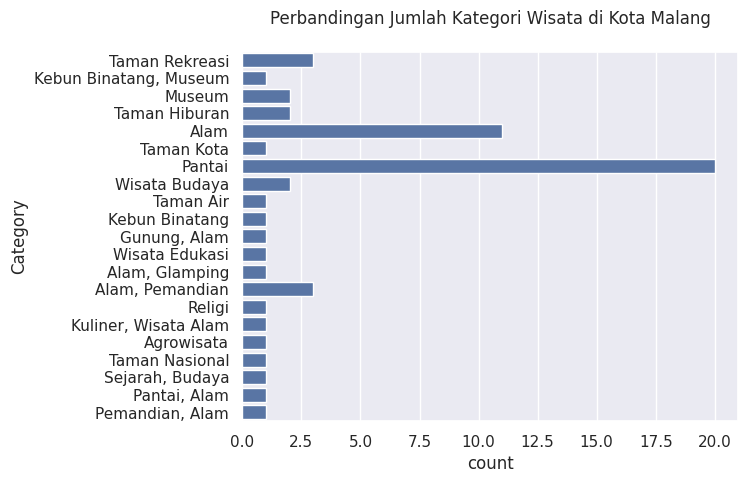

In [ ]:
# Membuat visualisasi jumlah kategori wisata di Kota malang

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata di Kota Malang', pad=20)
plt.show()

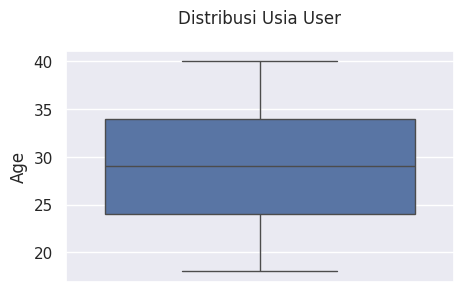

In [ ]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

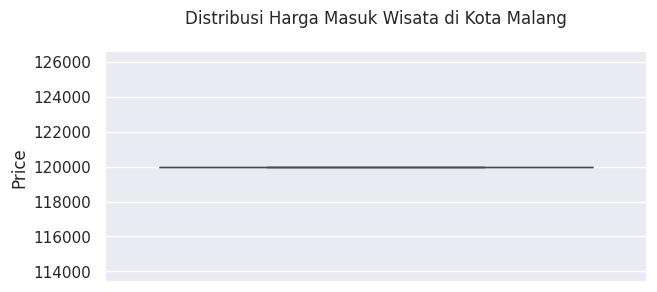

In [ ]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata di Kota Malang', pad=20)
plt.show()

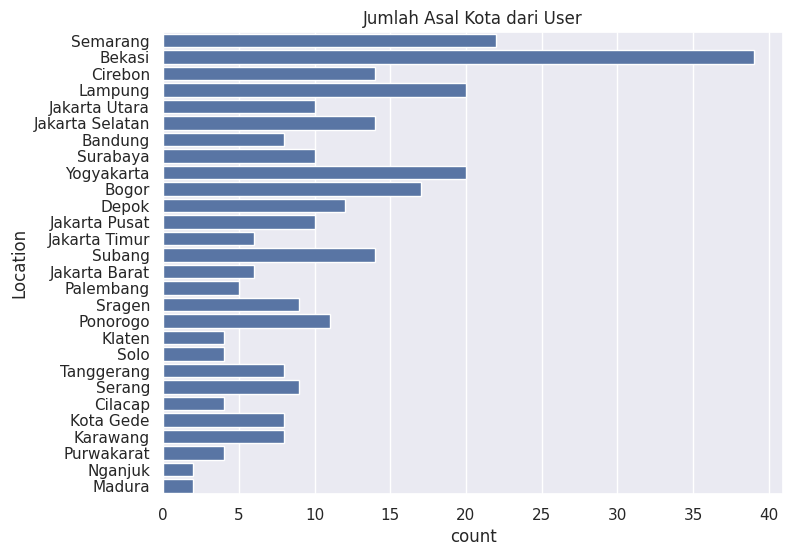

In [ ]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## 5. Persiapan Data untuk Pemodelan

### 5.1. Membuat Salinan Data rating

In [ ]:
# Membaca dataset untuk dilakukan encoding

df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings,Category
0,1,438,2,Taman Rekreasi
1,20,438,2,Taman Rekreasi
2,39,438,3,Taman Rekreasi
3,58,438,2,Taman Rekreasi
4,77,438,5,Taman Rekreasi


### 5.2. Melakukan Encoding

#### 5.2.1. Membuat Fungsi untuk Melakukan Encoding

In [ ]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

#### 5.2.2. Encoding dan Mapping Kolom User

In [ ]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [ ]:
df.head()

,User_Id,Place_Id,Place_Ratings,Category,user
0,1,438,2,Taman Rekreasi,0
1,20,438,2,Taman Rekreasi,1
2,39,438,3,Taman Rekreasi,2
3,58,438,2,Taman Rekreasi,3
4,77,438,5,Taman Rekreasi,4


#### 5.2.3. Encoding dan Mapping Kolom Place

In [ ]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [ ]:
df.head()

,User_Id,Place_Id,Place_Ratings,Category,user,place
0,1,438,2,Taman Rekreasi,0,0
1,20,438,2,Taman Rekreasi,1,0
2,39,438,3,Taman Rekreasi,2,0
3,58,438,2,Taman Rekreasi,3,0
4,77,438,5,Taman Rekreasi,4,0


In [ ]:
# Encoding Category
category_to_category_encoded, category_encoded_to_category = dict_encoder('Category')

# Mapping Category ke dataframe place
df['kategori'] = df['Category'].map(category_to_category_encoded)

In [ ]:
df.head()

,User_Id,Place_Id,Place_Ratings,Category,user,place,kategori
0,1,438,2,Taman Rekreasi,0,0,0
1,20,438,2,Taman Rekreasi,1,0,0
2,39,438,3,Taman Rekreasi,2,0,0
3,58,438,2,Taman Rekreasi,3,0,0
4,77,438,5,Taman Rekreasi,4,0,0


In [ ]:
df.to_csv('data.csv', index=False)

### 5.3. Melihat Gambaran Data untuk Pemodelan

In [ ]:
# Mendapatkan jumlah user dan place
num_users, num_place, num_category= len(user_to_user_encoded), len(place_to_place_encoded), len(category_to_category_encoded)
print(num_users, num_place, num_category)
# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

300 57 21
Number of User: 300, Number of Place: 57, Min Rating: 1.0, Max Rating: 5.0


In [67]:
print(num_places)

NameError: name 'num_places' is not defined

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings,Category,user,place,kategori
203,258,476,2.0,"Sejarah, Budaya",203,38,18
266,232,488,3.0,Pantai,266,50,6


## 6. Pemodelan Machine Learning dengan RecommenderNet

### 6.1. Membagi data train dan test

In [79]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place', 'kategori']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.80 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### 6.2. Menyiapkan Model

#### 6.2.1. Inisialisasi Fungsi

In [80]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_places, num_categories, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.num_categories = num_categories
    self.embedding_size = embedding_size

#=========================== START BATAS WKWKWKW ==============================

    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-1)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias

#=============================================================================
#============================ BATAS WKWKWK 1 =================================

    self.places_embedding = layers.Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-1)
    )
    self.places_bias = layers.Embedding(num_places, 1) # layer embedding places bias

#===============================================================================
#=============================== BATAS WKWKWK 2 ================================

    self.categories_embedding = layers.Embedding( # layer embeddings places
        num_categories,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-1)
    )
    self.categories_bias = layers.Embedding(num_categories, 1) # layer embedding places bias

#=================================================================================
#================================ BATAS AHIR WKWKWK  =================================


    self.user_dropout = layers.Dropout(0.5)  # Contoh dropout dengan rate 0.5
    self.places_dropout = layers.Dropout(0.5)  # Contoh dropout dengan rate 0.5
    self.categories_dropout = layers.Dropout(0.5)  # Contoh dropout dengan rate 0.5

  def call(self, inputs):
    #user_vector = self.user_dropout(user_vector)
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # memanggil layer embedding 3
    #user_vector = self.user_dropout(user_vector)
    places_bias = self.places_bias(inputs[:, 1]) # memanggil layer embedding 4
    categories_vector = self.categories_embedding(inputs[:, 2])
    categories_bias = self.categories_bias(inputs[:, 2])

    dot_user_places_categories = tf.tensordot(user_vector, places_vector, categories_vector, 2)# default = 2

    x = dot_user_places_categories + user_bias + places_bias + categories_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [65]:
print(num_place)

57


#### 6.2.2. Inisialisasi Model

In [76]:
#model = RecommenderNet(num_users, num_place, 50) # inisialisasi model

model = RecommenderNet(num_users, num_place, num_category, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

#### 6.2.2. Inisialisasi Callbacks

In [77]:
 class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

#### 6.2.3. Proses Training

In [78]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks = [myCallback()]
)

Epoch 1/100


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file1q029v4m.py", line 16, in tf__call
        dot_user_places_categories = ag__.converted_call(ag__.ld(tf).tensordot, (ag__.ld(user_vector), ag__.ld(places_vector), ag__.ld(categories_vector), 2), None, fscope)
    File "/usr/lib/python3.10/contextlib.py", line 135, in __enter__
        return next(self.gen)

    TypeError: Exception encountered when calling layer 'recommender_net_1' (type RecommenderNet).
    
    in user code:
    
        File "<ipython-input-75-4fd6f67f798a>", line 61, in call  *
            dot_user_places_categories = tf.tensordot(user_vector, places_vector, categories_vector, 2)# default = 2
        File "/usr/lib/python3.10/contextlib.py", line 135, in __enter__
            return next(self.gen)
    
        TypeError: expected string or bytes-like object
    
    
    Call arguments received by layer 'recommender_net_1' (type RecommenderNet):
      • inputs=tf.Tensor(shape=(None, 3), dtype=int64)


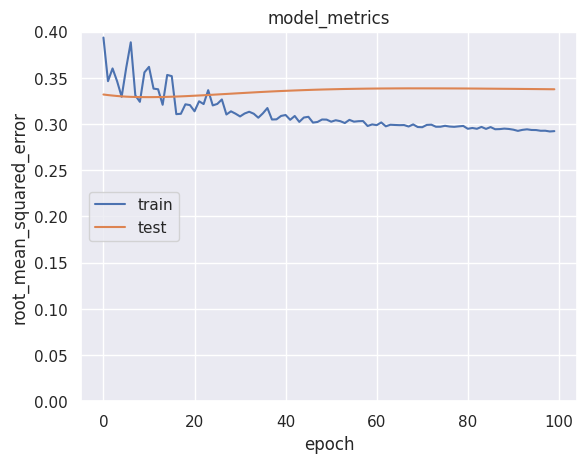

In [ ]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

In [ ]:
# Simpan model ke dalam format SavedModel TensorFlow
model.save("recommender_model", save_format="tf")


In [ ]:
# Simpan bobot model ke dalam file
model.save_weights("recommender_model_weights.h5")


## 7. Memprediksi Top 7 Rekomendasi

#### 7.1 Menyiapkan DataFrame untuk Menampilkan Hasil Rekomendasi

In [ ]:
# Menyiapkan dataframe
place_df = place[['Place_Id','Place_Name','Category','Rating','Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()

In [ ]:
#df.to_csv('rating_baru.csv', index=False)
#place.to_csv('place_malang.csv', index=False)
#place_to_place_encoded.head(2)
print(user_place_array)

[[82  0]
 [82  1]
 [82  2]
 [82  3]
 [82  4]
 [82  5]
 [82  6]
 [82  7]
 [82  8]
 [82  9]
 [82 10]
 [82 11]
 [82 12]
 [82 13]
 [82 14]
 [82 16]
 [82 17]
 [82 18]
 [82 19]
 [82 20]
 [82 21]
 [82 22]
 [82 23]
 [82 24]
 [82 25]
 [82 26]
 [82 27]
 [82 28]
 [82 29]
 [82 30]
 [82 31]
 [82 32]
 [82 33]
 [82 34]
 [82 35]
 [82 36]
 [82 37]
 [82 38]
 [82 39]
 [82 40]
 [82 41]
 [82 42]
 [82 43]
 [82 44]
 [82 45]
 [82 46]
 [82 47]
 [82 48]
 [82 49]
 [82 50]
 [82 51]
 [82 52]
 [82 53]
 [82 54]
 [82 55]
 [82 56]]


#### 7.2. Menyiapkan contoh User untuk Menampilkan Rekomendasi

#### 7.2.1 Mencari User

In [ ]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

#### 7.2.2. Mencari Lokasi yang belum Dikunjungi User

In [ ]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

### 7.3. Menampilkan Hasil Rekomendasi untuk User

In [ ]:
# Mengambil top 7 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)

recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Harga Tiket Masuk ', row.price, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)

2/2 [==============================] - 0s 7ms/step
Daftar rekomendasi untuk: User 283

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
Coban Sewu : Alam

------------------------------------------------------------
Top 7 place recommendation
------------------------------------------------------------
1 . Bukit Teletubbies Bromo 
     Alam , Harga Tiket Masuk  nan , Rating Wisata  4.6 

2 . Sumber Maron 
     Alam, Pemandian , Harga Tiket Masuk  nan , Rating Wisata  4.3 

3 . Masjid Tiban Turen 
     Religi , Harga Tiket Masuk  nan , Rating Wisata  4.4 

4 . Pantai Batu Bengkung 
     Pantai , Harga Tiket Masuk  nan , Rating Wisata  4.5 

5 . Pantai Kondang Merak 
     Pantai , Harga Tiket Masuk  nan , Rating Wisata  4.5 

6 . Pantai banyu Anjlok 
     Pantai, Alam , Harga Tiket Masuk  nan , Rating Wisata  4.6 

7 . Pantai Tamban 
     Pantai , Harga Tiket Masuk

In [ ]:
!zip -r recommender_model.zip recommender_model/


  adding: recommender_model/ (stored 0%)
  adding: recommender_model/saved_model.pb (deflated 89%)
  adding: recommender_model/variables/ (stored 0%)
  adding: recommender_model/variables/variables.index (deflated 58%)
  adding: recommender_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: recommender_model/keras_metadata.pb (deflated 82%)
  adding: recommender_model/assets/ (stored 0%)
  adding: recommender_model/fingerprint.pb (stored 0%)


In [ ]:

files.download('nama_folder.zip')


'/content'

# Penutup

Model untuk menampilkan top 7 rekomendasi tempat wisata telah selesai dibuat dan model ini dapat digunakan untuk menampilkan rekomendasi kepada user yang harapannya dapat meningkatkan jumlah wisatawan di Kota Bandung. Namun demikian beberapa pengembangan lain masih dapat dilakukan agar dapat membuat model yang menampilkan rekomendasi yang lebih sesuai dengan kebiasaan pengguna, dll.

## *Referensi*

* Seaborn : https://seaborn.pydata.org/tutorial.html
* Callback : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
* Lainnya:
  * https://github.com/AgungP88/getloc-apps/tree/machine-learning
  * https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
  * https://www.kaggle.com/aprabowo/indonesia-tourism-destination
  * https://www.dicoding.com/academies/319